In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set download directory
download_dir = "/content/drive/MyDrive/Kaggle"

# Create the directory if it doesn't exist
os.makedirs(download_dir, exist_ok=True)


# Upload kaggle.json (if not already uploaded)
from google.colab import files

# Option 1: Upload kaggle.json directly in Colab
# Uncomment the next line if you haven't uploaded the kaggle.json yet
# uploaded = files.upload()

# Configure Kaggle
os.makedirs('/root/.kaggle', exist_ok=True)
!cp /content/drive/MyDrive/Kaggle/kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# Import and authenticate Kaggle API
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset URL: https://www.kaggle.com/datasets/dataset-owner/dataset-name


ApiException: (403)
Reason: Forbidden
HTTP response headers: HTTPHeaderDict({'Content-Type': 'application/json', 'Date': 'Tue, 26 Nov 2024 16:15:31 GMT', 'Access-Control-Allow-Credentials': 'true', 'Access-Control-Allow-Origin': '*', 'Set-Cookie': 'ka_sessionid=22a06c82deefa75e6ed86e7350e46805; max-age=2626560; path=/, GCLB=CN2h5tHXzb-nCRAD; path=/; HttpOnly', 'Vary': 'Accept-Encoding', 'X-Kaggle-MillisecondsElapsed': '24', 'X-Kaggle-RequestId': '1ad718c321724e07e2db2893c59088d4', 'X-Kaggle-ApiVersion': '1.6.17', 'X-Kaggle-HubVersion': '0.3.4', 'X-Frame-Options': 'SAMEORIGIN', 'Strict-Transport-Security': 'max-age=63072000; includeSubDomains; preload', 'Content-Security-Policy': "object-src 'none'; script-src 'nonce-wxsjaTzKvKcwwLutrhym+g==' 'report-sample' 'unsafe-inline' 'unsafe-eval' 'strict-dynamic' https: http:; base-uri 'none'; report-uri https://csp.withgoogle.com/csp/kaggle/20201130; frame-src 'self' https://www.kaggleusercontent.com https://www.youtube.com/embed/ https://polygraph-cool.github.io https://www.google.com/recaptcha/ https://www.docdroid.com https://www.docdroid.net https://kaggle-static.storage.googleapis.com https://kkb-production.jupyter-proxy.kaggle.net https://kkb-production.firebaseapp.com https://kaggle-metastore.firebaseapp.com https://apis.google.com https://content-sheets.googleapis.com/ https://accounts.google.com/ https://storage.googleapis.com https://docs.google.com https://drive.google.com https://calendar.google.com/ ;", 'X-Content-Type-Options': 'nosniff', 'Referrer-Policy': 'strict-origin-when-cross-origin', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000', 'Transfer-Encoding': 'chunked'})
HTTP response body: b'{"code":403,"message":"Permission \\u0027datasets.get\\u0027 was denied"}'


In [ ]:

api.dataset_download_files('rashikrahmanpritom/plant-disease-recognition-dataset', path=download_dir, unzip=True)

print(f"Downloaded files to: {download_dir}")

Dataset URL: https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset
Downloaded files to: /content/drive/MyDrive/Kaggle


In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
train_dir = '/content/drive/MyDrive/Kaggle/Train/Train'
test_dir = '/content/drive/MyDrive/Kaggle/Test/Test'
val_dir = '/content/drive/MyDrive/Kaggle/Validation/Validation'

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 1322 images belonging to 3 classes.


In [ ]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 60 images belonging to 3 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

Found 150 images belonging to 3 classes.


In [ ]:
class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)

Class Names: ['Healthy', 'Powdery', 'Rust']


In [ ]:
def show_images_for_class(class_name, directory, num_images=5):
    class_path = os.path.join(directory, class_name)
    images = os.listdir(class_path)[:num_images]
    plt.figure(figsize=(15, 5))
    for i, image_name in enumerate(images):
        image_path = os.path.join(class_path, image_name)
        img = Image.open(image_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name)
    plt.show()

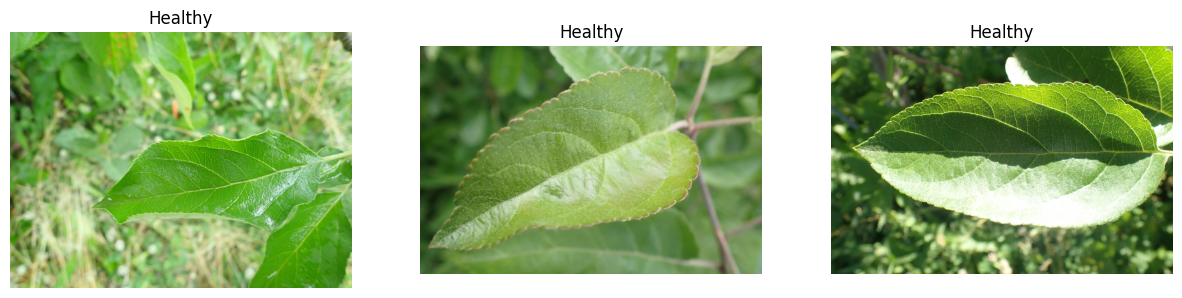

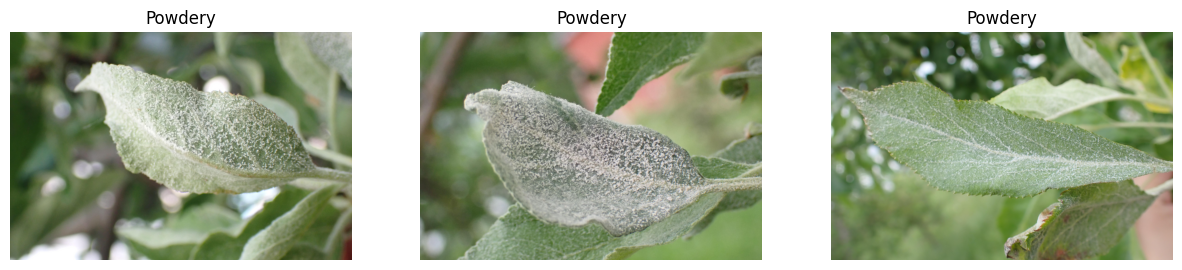

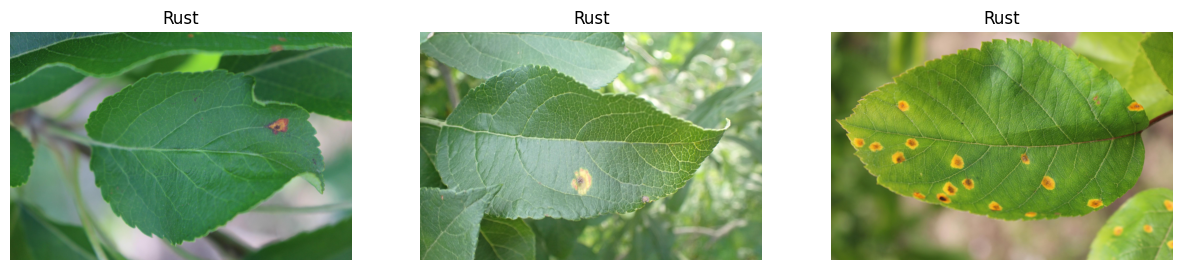

In [ ]:
for class_name in class_names:
    show_images_for_class(class_name, train_dir, num_images=3)

In [ ]:
model = Sequential([

    Input(shape=(224, 224, 3)),

    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(3, activation='softmax')
])

In [ ]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,536,675 (36.38 MB)

 Trainable params: 9,536,675 (36.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.4516 - loss: 1.0241 - val_accuracy: 0.7667 - val_loss: 0.6112
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.7656 - loss: 0.5811 - val_accuracy: 0.7167 - val_loss: 0.7024
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8201 - loss: 0.4914 - val_accuracy: 0.8667 - val_loss: 0.4917
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.8703 - loss: 0.3724 - val_accuracy: 0.8500 - val_loss: 0.4758
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8787 - loss: 0.3546 - val_accuracy: 0.8667 - val_loss: 0.4018
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.8893 - loss: 0.3237 - val_accuracy: 0.8333 - val_loss: 0.4623
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9002 - loss: 0.2855 - val_accuracy: 0.9167 - val_loss: 0.2790
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9326 - loss: 0.2040 - val_accuracy: 0.9500 - val_loss: 0.1

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9262 - loss: 0.2058
Test Loss: 0.16993136703968048, Test Accuracy: 0.9466666579246521


In [ ]:
def evaluate_model(model, test_generator):

    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    class_labels = list(test_generator.class_indices.keys())

    # Classification Report
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Kaggle/leaf_disease_model.h5')



In [ ]:
!pip install coremltools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.9 MB/s eta 0:00:00


In [ ]:
import coremltools as ct
import tensorflow as tf

# Try TensorFlow Lite conversion method
def convert_model_to_tflite(model):
    # Convert the model to TensorFlow Lite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    # Optional: Apply optimizations
    converter.optimizations = [tf.lite.Optimize.DEFAULT]

    # Try quantization
    try:
        converter.target_spec.supported_types = [tf.float16]
    except:
        print("Quantization not supported, using default conversion")

    # Convert the model
    tflite_model = converter.convert()

    # Save the TensorFlow Lite model
    with open('/content/drive/MyDrive/Kaggle/leaf_disease_model.tflite', 'wb') as f:
        f.write(tflite_model)

    print("TensorFlow Lite model saved successfully!")

# Attempt conversion
try:
    # Ensure the model is not in training mode
    model.trainable = False

    # Convert to TensorFlow Lite
    convert_model_to_tflite(model)
except Exception as e:
    print(f"TFLite conversion error: {e}")

Saved artifact at '/tmp/tmp4sq9116w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137550764448528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137550762375152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137550761952528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137550762650160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137550762652096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137550762648048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137550762653856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137550762649456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137550762654208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137550762655088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13755076263942

In [ ]:
import tensorflow as tf

# Save the model in TensorFlow SavedModel format
tf.saved_model.save(
    model,  # The model you want to save
    export_dir='/content/drive/MyDrive/Kaggle/leaf_disease_model_saved'  # Directory to save the model
)


In [ ]:
import coremltools as ct

mlmodel = ct.convert(
    '/content/drive/MyDrive/Kaggle/leaf_disease_model_saved',  # Path to the SavedModel directory
    source="tensorflow",
    inputs=[ct.ImageType(shape=(1, 224, 224, 3))],  # Specify input shape
    classifier_config=ct.ClassifierConfig(class_labels=['Healthy', 'Powdery', 'Rust'])
)

mlmodel.save('/content/drive/MyDrive/Kaggle/PlantDiseaseClassifier.mlpackage')


Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 217.37 passes/s]
